# Glassdoor HR Review Detector

# 1. Theory

- The kinds of words that genuine employees use in glassdoor review is different from the one used by HR.
- So my theory is that I can use AI to distinguist between these two kind of reviews.
- This will be achived using embeddings. An embedding is a coversion of natural language to vectors. Vectors of similar words are close to each other. My theory is that one or more regions of of the vector space are more of the human resources kind while other regions are more of the genuine employee kinds.
- My goal is to train a neural network to identify regions in the vector space that are "hr"-ish vs. regions that are "genuine"-ish. Based on this, given a review text, the network will be able to predict if the review was written by HR or not.


- Training data consists of pros, cons, overall review, sounds like hr
- pros, cons represented as vector embeddings using openai api

> **NOTE**: How is the `sounds_like_hr` field set in the training data? The answer is that I set it based on my gut instinct! **Please do not take this project seriously**, it's just an excuse to try out machine learning algorithms. For context: I used Glassdoor in the past and suspected some reviews were written by HR; either because they would say there are no cons or they would pander to the company like 'you have to work late, but it's worth it'. I thought it would be a fun project to build an AI that could detect this based on my instinct rather than emperical data.

## 1.1 Setup

In [4]:
import csv
import tempfile
import numpy as np
from IPython.display import display, HTML
from utils.utils import load_csv_as_dictionary, array_of_dictionaries_to_csv_string
from sklearn.model_selection import train_test_split
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_chroma import Chroma
import pandas as pd
from openai import OpenAI
import ast

openaiClient = OpenAI()

In [5]:
# 1. load csv as array of objects 
training_data = load_csv_as_dictionary(csv_filename='training-data/glassdoor-reviews-main.csv')

In [6]:
import concurrent.futures
import os

def file_exists_and_not_empty(file_path):
    return os.path.isfile(file_path) and os.path.getsize(file_path) > 0

def get_embedding(text, model="text-embedding-3-small",dimensions=256):
    text = text.replace("\n", "")
    return openaiClient.embeddings.create(input=[text], model=model, dimensions=dimensions).data[0].embedding

def add_embeddings_to_data(data={}, dimensions=256):
    def process_item(item):
        item['sounds_like_hr'] = int(item['sounds_like_hr']) == 1
        item['pros_embedding'] = get_embedding(item['pros'], dimensions=dimensions)
        item['cons_embedding'] = get_embedding(item['cons'], dimensions=dimensions)
        return item

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_item, data))

    return pd.DataFrame(results)

EMBEDDINGS_CSV = "./embeddings/full_training_data.csv"
if file_exists_and_not_empty(EMBEDDINGS_CSV):
    training_df = pd.read_csv(EMBEDDINGS_CSV)
    training_df['pros_embedding'] = training_df['pros_embedding'].apply(lambda x: np.array(ast.literal_eval(x)))
    training_df['cons_embedding'] = training_df['cons_embedding'].apply(lambda x: np.array(ast.literal_eval(x)))
else:
    training_df = add_embeddings_to_data(data=training_data)
    training_df.to_csv(EMBEDDINGS_CSV)

In [7]:
display(training_df)

,Unnamed: 0,empReview_id,date,overall_rating,pros,cons,sounds_like_hr,pros_embedding,cons_embedding
0,0,empReview_17495196,"Oct 23, 2017",4.0,Great growth and great people.,"As in every startup, things tend to be unstruc...",True,"[0.05013425275683403, 0.016153760254383087, 0....","[-0.046581801027059555, 0.09486118704080582, 0..."
1,1,empReview_39824426,"Dec 27, 2020",4.0,Used to be great culture now there is none,Management let go people without an ounce of k...,False,"[-0.036672014743089676, 0.006614204496145248, ...","[0.06731574237346649, 0.11190391331911087, -0...."
2,2,empReview_53053107,"Sep 24, 2021",3.0,"Competitive packages, good work environment","No work life balance, rotational shifts",False,"[-0.031563591212034225, -0.05921819806098938, ...","[-0.06812486052513123, 0.1267542988061905, 0.1..."
3,3,empReview_8252989,"Oct 10, 2015",4.0,its a very good startup company they got raise...,actually nothing to say about cons.,True,"[0.06713095307350159, -0.00833177100867033, 0....","[0.06517201662063599, -0.0013001225888729095, ..."
4,4,empReview_17495063,"Oct 23, 2017",5.0,fast pace multi cultural environment,Nothing negative to add here,True,"[0.06553180515766144, 0.039654362946748734, 0....","[-0.06871257722377777, -0.02405824325978756, -..."
...,...,...,...,...,...,...,...,...,...
346,346,empReview_85736752,"Mar 26, 2024",4.0,Nice place to work higher management is the be...,In my case Line manager are not eligible for t...,False,"[-0.05264364555478096, 0.0022777230478823185, ...","[-0.05477072298526764, 0.1417725533246994, 0.0..."
347,347,empReview_79937582,"Sep 11, 2023",1.0,What attracted me to parent company was the mi...,It's a total disaster from the top down. They ...,False,"[-0.06940412521362305, -0.05084717273712158, -...","[0.00357118365354836, 0.08031114935874939, 0.0..."
348,348,empReview_85832570,"Mar 29, 2024",2.0,Best people in the region,Work life balance is not good. Busy work is re...,False,"[-0.00355895864777267, -0.045777976512908936, ...","[0.02340914122760296, 0.09341533482074738, 0.1..."
349,349,empReview_85700157,"Mar 25, 2024",4.0,Exponential Learning | Fitness Reimbursement |...,Hire slow fire fast culture | More than averag...,False,"[0.07080849260091782, 0.010619708336889744, 0....","[0.05213627591729164, 0.0846911370754242, 0.04..."


In [8]:
review_genuity_dict = {item["empReview_id"]: item["sounds_like_hr"] for item in training_data}

# 2. Visualising the Embeddings

We will compare the embeddings of pros and cons of genuine and HR written reviews to see their relative position in the embedding vector space. 

Given my observation that either:
- HR written cons claim there aren't any e.g. "no cons", "Can't think of any, really.", "nothing to mention everything is going great"
- HR written cons tend to be PR friendly e.g. "you'll need to work late but that is expected for a startup"
Then
- The embedding of HR cons will have some specific clusters, corresponding to e.g. "no cons" and/or "late sittings"
- The embedding of HR cons will overlap with pros.

First, let's see what embeddings look like

In [9]:
training_df[training_df['sounds_like_hr'] == False]['pros_embedding']

1      [-0.036672014743089676, 0.006614204496145248, ...
2      [-0.031563591212034225, -0.05921819806098938, ...
5      [-0.04129469767212868, -0.002414990682154894, ...
6      [0.03806692361831665, 0.09841836243867874, 0.1...
7      [-0.05781371891498566, 0.06491882354021072, 0....
                             ...                        
345    [-0.022108115255832672, 0.05842430144548416, 0...
346    [-0.05264364555478096, 0.0022777230478823185, ...
347    [-0.06940412521362305, -0.05084717273712158, -...
348    [-0.00355895864777267, -0.045777976512908936, ...
349    [0.07080849260091782, 0.010619708336889744, 0....
Name: pros_embedding, Length: 283, dtype: object

In [10]:
genuine_pros_matrix = np.array(training_df[training_df['sounds_like_hr'] == False]['pros_embedding'].tolist())
genuine_cons_matrix = np.array(training_df[training_df['sounds_like_hr'] == False]['cons_embedding'].tolist())
hr_pros_matrix = np.array(training_df[training_df['sounds_like_hr'] == True]['pros_embedding'].tolist())
hr_cons_matrix = np.array(training_df[training_df['sounds_like_hr'] == True]['cons_embedding'].tolist())
print(f"Geninuine Pros Embedding Shape: {genuine_pros_matrix.shape}")
print(f"Geninuine Cons Embedding Shape: {genuine_cons_matrix.shape}")
print(f"HR Pros Embedding Shape: {hr_pros_matrix.shape}")
print(f"HR Cons Embedding Shape: {hr_cons_matrix.shape}")

Geninuine Pros Embedding Shape: (283, 256)
Geninuine Cons Embedding Shape: (283, 256)
HR Pros Embedding Shape: (68, 256)
HR Cons Embedding Shape: (68, 256)


## 2.1 Principal Component Analysis

We can see here that each review has 256 parameters. In order to visualise the relative position of embeddings, we will need to perform principal component analysis


In [11]:
from sklearn.decomposition import PCA

# Loading the PCA algorithm
pca_3 = PCA(n_components=3)
# Let's fit the data. We do not need to scale it, since sklearn's implementation already handles it.
pca_3.fit(genuine_pros_matrix)
print(f"Explained Variance Ratio: {pca_3.explained_variance_ratio_}")

genuine_pros_pca_3d = pca_3.transform(genuine_pros_matrix)
genuine_cons_pca_3d = pca_3.transform(genuine_cons_matrix)
hr_pros_pca_3d = pca_3.transform(hr_pros_matrix)
hr_cons_pca_3d = pca_3.transform(hr_cons_matrix)
print(genuine_pros_pca_3d.shape)
print(genuine_cons_pca_3d.shape)
print(hr_pros_pca_3d.shape)
print(hr_cons_pca_3d.shape)

Explained Variance Ratio: [0.05844204 0.05676322 0.04878819]
(283, 3)
(283, 3)
(68, 3)
(68, 3)


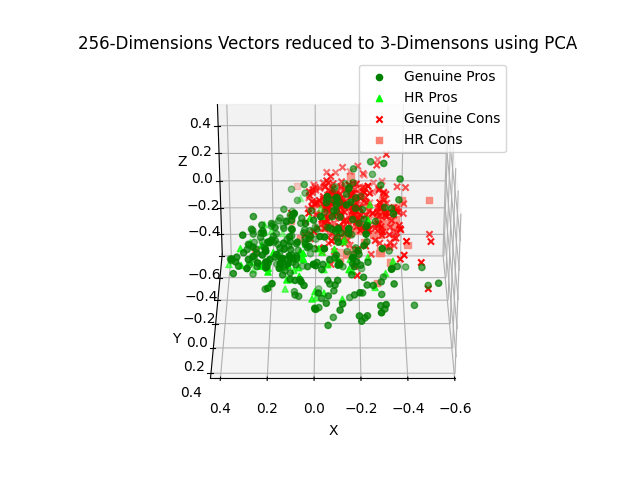

In [12]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot genuine_pros_matrix
ax.scatter(genuine_pros_pca_3d[:, 0], genuine_pros_pca_3d[:, 1], genuine_pros_pca_3d[:, 2], c='g', marker='o', label='Genuine Pros')

# Plot hr_pros_matrix
ax.scatter(hr_pros_pca_3d[:, 0], hr_pros_pca_3d[:, 1], hr_pros_pca_3d[:, 2], c='lime', marker='^', label='HR Pros')

# Plot genuine_cons_matrix
ax.scatter(genuine_cons_pca_3d[:, 0], genuine_cons_pca_3d[:, 1], genuine_cons_pca_3d[:, 2], c='r', marker='x', label='Genuine Cons')

# Plot hr_cons_matrix
ax.scatter(hr_cons_pca_3d[:, 0], hr_cons_pca_3d[:, 1], hr_cons_pca_3d[:, 2], c='salmon', marker='s', label='HR Cons')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('256-Dimensions Vectors reduced to 3-Dimensons using PCA')
ax.legend()

ax.view_init(elev=30, azim=90)


plt.show()


*Note: While researching, I came across something called [TSNE](https://cookbook.openai.com/examples/visualizing_embeddings_in_2d). Saving it here to study more about it later.*

## 2.2 3-D Embeddings

In [13]:
training_df_3d = add_embeddings_to_data(data=training_data,dimensions=3)
display(training_df_3d)

,empReview_id,date,overall_rating,pros,cons,sounds_like_hr,pros_embedding,cons_embedding
0,empReview_17495196,"Oct 23, 2017",4.0,Great growth and great people.,"As in every startup, things tend to be unstruc...",True,"[0.9409016966819763, 0.3023039400577545, 0.152...","[-0.377630352973938, 0.7706966400146484, 0.513..."
1,empReview_39824426,"Dec 27, 2020",4.0,Used to be great culture now there is none,Management let go people without an ounce of k...,False,"[-0.9584963321685791, 0.17283636331558228, -0....","[0.514417290687561, 0.855941116809845, -0.0523..."
2,empReview_53053107,"Sep 24, 2021",3.0,"Competitive packages, good work environment","No work life balance, rotational shifts",False,"[-0.29876530170440674, -0.5612914562225342, 0....","[-0.3359939157962799, 0.6242578625679016, 0.70..."
3,empReview_8252989,"Oct 10, 2015",4.0,its a very good startup company they got raise...,actually nothing to say about cons.,True,"[0.8010952472686768, -0.09978155791759491, 0.5...","[0.789611279964447, -0.015538574196398258, 0.6..."
4,empReview_17495063,"Oct 23, 2017",5.0,fast pace multi cultural environment,Nothing negative to add here,True,"[0.542421281337738, 0.32761842012405396, 0.773...","[-0.8080808520317078, -0.2832448184490204, -0...."
...,...,...,...,...,...,...,...,...
346,empReview_85736752,"Mar 26, 2024",4.0,Nice place to work higher management is the be...,In my case Line manager are not eligible for t...,False,"[-0.40069666504859924, 0.06986651569604874, 0....","[-0.3311557471752167, 0.860205352306366, 0.387..."
347,empReview_79937582,"Sep 11, 2023",1.0,What attracted me to parent company was the mi...,It's a total disaster from the top down. They ...,False,"[-0.6502012610435486, -0.475718230009079, -0.5...","[0.03647797182202339, 0.8203408718109131, 0.57..."
348,empReview_85832570,"Mar 29, 2024",2.0,Best people in the region,Work life balance is not good. Busy work is re...,False,"[-0.0730823427438736, -0.9232111573219299, 0.3...","[0.1662631332874298, 0.6650525331497192, 0.728..."
349,empReview_85700157,"Mar 25, 2024",4.0,Exponential Learning | Fitness Reimbursement |...,Hire slow fire fast culture | More than averag...,False,"[0.5224361419677734, 0.07831935584545135, 0.84...","[0.477755606174469, 0.7768746018409729, 0.4101..."


In [14]:
genuine_pros_3d = np.array(training_df_3d[training_df_3d['sounds_like_hr'] == False]['pros_embedding'].tolist())
genuine_cons_3d = np.array(training_df_3d[training_df_3d['sounds_like_hr'] == False]['cons_embedding'].tolist())
hr_pros_3d = np.array(training_df_3d[training_df_3d['sounds_like_hr'] == True]['pros_embedding'].tolist())
hr_cons_3d = np.array(training_df_3d[training_df_3d['sounds_like_hr'] == True]['cons_embedding'].tolist())

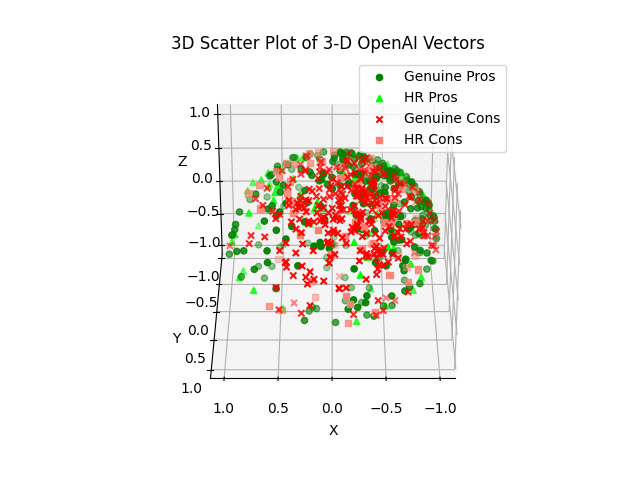

In [15]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot genuine_pros_matrix
ax.scatter(genuine_pros_3d[:, 0], genuine_pros_3d[:, 1], genuine_pros_3d[:, 2], c='g', marker='o', label='Genuine Pros')

# Plot hr_pros_matrix
ax.scatter(hr_pros_3d[:, 0], hr_pros_3d[:, 1], hr_pros_3d[:, 2], c='lime', marker='^', label='HR Pros')

# Plot genuine_cons_matrix
ax.scatter(genuine_cons_3d[:, 0], genuine_cons_3d[:, 1], genuine_cons_3d[:, 2], c='r', marker='x', label='Genuine Cons')

# Plot hr_cons_matrix
ax.scatter(hr_cons_3d[:, 0], hr_cons_3d[:, 1], hr_cons_3d[:, 2], c='salmon', marker='s', label='HR Cons')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot of 3-D OpenAI Vectors')
ax.legend()

ax.view_init(elev=30, azim=90)


plt.show()


# 3.Neural Network

In [16]:
import logging
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [17]:
m = training_df.shape[0]
x = np.zeros((m, 513))
y = np.zeros((m,1))
for i in range(m):
    item = training_df.iloc[i]
    x[i, 0] = float(item['overall_rating'])  # First element is the rating
    x[i, 1:257] = item['pros_embedding']  # Next 256 elements are the pros embeddings
    x[i, 257:] = item['cons_embedding']  # Last 256 elements are the cons embeddings
    y[i,0] = item['sounds_like_hr']
print(x.shape)

(351, 513)


In [18]:
# 2. use scikit learn to split into training and test set?
x_train,x_cv_and_test, y_train,y_cv_and_test = train_test_split(x,y, test_size=0.40, random_state=1)
x_cv,x_test, y_cv,y_test = train_test_split(x_cv_and_test,y_cv_and_test, test_size=0.50, random_state=1)

del x_cv_and_test
del y_cv_and_test
print(f"Training Set Shape: {x_train.shape}, {y_train.shape}")
print(f"Validation Set Shape: {x_cv.shape}, {y_cv.shape}")
print(f"Test Set Shape: {x_test.shape}, {y_test.shape}")

Training Set Shape: (210, 513), (210, 1)
Validation Set Shape: (70, 513), (70, 1)
Test Set Shape: (71, 513), (71, 1)


In [19]:
models = [Sequential([
    Dense(25, activation = 'relu'),
    Dense(15, activation = 'relu'),
    Dense(1, activation = 'linear')
],name='min'),Sequential([
    Dense(100, activation = 'relu'),
    Dense(50, activation = 'relu'),
    Dense(1, activation = 'linear')
],name='med'),Sequential([
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(1, activation = 'linear')
],name='max')]

# Set the threshold for classification
threshold = 0.5

results = []

for model in models:

    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

    print(f"Training {model.name}...")

    # Train the model
    model.fit(
        x_train, y_train,
        epochs=200,
        verbose=0
    )
    
    print("Done!\n")
    
    
    # Record the fraction of misclassified examples for the training set
    yhat = model.predict(x_train)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    train_error = np.mean(yhat != y_train)

    # Record the fraction of misclassified examples for the cross validation set
    yhat = model.predict(x_cv)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    cv_error = np.mean(yhat != y_cv)

    results.append({"Name":model.name,"Training Set Error":train_error,"CV Set Error":cv_error})

model_performance = pd.DataFrame(results)
display(model_performance)

# Determine the best model based on CV Set Error
best_model_info = model_performance.loc[model_performance['CV Set Error'].idxmin()]
best_model_name = best_model_info['Name']
best_model = next(model for model in models if model.name == best_model_name)

print(f"'{best_model_name}' performed best with a CV Error of {best_model_info['CV Set Error']:.4f}")


Training min...
Done!

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step
Training med...
Done!

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
Training max...
Done!

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step


,Name,Training Set Error,CV Set Error
0,min,0.0,0.114286
1,med,0.0,0.128571
2,max,0.0,0.157143


'min' performed best with a CV Error of 0.1143


In [20]:
# Compute the test error
yhat = best_model.predict(x_test)
yhat = tf.math.sigmoid(yhat)
yhat = np.where(yhat >= threshold, 1, 0)
nn_test_error = np.mean(yhat != y_test)

print(f"Test Set Classification Error: {nn_test_error:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
Test Set Classification Error: 0.1268


In [55]:
def create_instance(rating,pros,cons):
    x = np.zeros((1, 513))
    x[0, 0] = float(rating)
    x[0, 1:257] = get_embedding(pros)  
    x[0, 257:] =  get_embedding(cons)
    return x

def test_sounds_like_hr(model,x,threshold=0.5):
    yhat = model.predict(x)
    print(yhat)
    yhat = tf.math.sigmoid(yhat)
    return yhat > 0.5

x = create_instance(3.0,"Competitive packages, good work environment","No work life balance, rotational shifts")
sounds_likr_hr = test_sounds_like_hr(model=best_model,x=x)  
display(sounds_likr_hr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[[-44.372566]]


<tf.Tensor: shape=(1, 1), dtype=bool, numpy=array([[False]])>

In [24]:
best_model.export("./glassdoor_hr_detection_model/v1")

Saved artifact at './glassdoor_hr_detection_model/v1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 513), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  12970833296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12970834448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12970833488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12970835600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12970834832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12970835792: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [71]:
import requests
import json

x = create_instance(2.0,"The salary is good. you will learn new stuff and your skills will be raised.","If you are working in the front line (Customer Services), most likely you will take much medicine because of the pressure")
response = requests.post('http://localhost:8501/v1/models/glassdoor_hr_review_detector:predict',
             json={
                 "instances": [
                    x[0].tolist()
                 ]})

print(response.status_code)
print(response.json())
print(tf.math.sigmoid(response.json()['predictions']) > 0.5)

200
{'predictions': [[-17.5167904]]}
tf.Tensor([[False]], shape=(1, 1), dtype=bool)


# 4. Pending Items
1. What if we used Llama instead of OpenAI. 